In [1]:
%pylab inline --no-import-all
import copy

Populating the interactive namespace from numpy and matplotlib


In [2]:
players_filename = "task_1_data/test_A/players.txt"
teams_filename = "task_1_data/test_A/teams.txt"

## Reading data from file

I intendedly calculate records count first in order not to read all the data in memory. Then players records are stored in an array of 2-byte integers. After that teams ratings are calculated one by one and storded in an array

In [3]:
players_count = sum(1 for line in open(players_filename))

with open(players_filename) as f:
    players_ratings = np.zeros((players_count,), dtype='uint16')
    for i in range(players_count):
        rating = f.readline().split(" ")[1]
        players_ratings[i] = rating

        
teams_count = sum(1 for line in open(teams_filename))

with open(teams_filename) as f:
    teams_ratings = np.zeros((teams_count,), dtype='int32')
    for i in range(teams_count):
        team_players_ratings = map(lambda idx: players_ratings[int(idx)], f.readline().split(" ")[1:])
        teams_ratings[i] = np.sum(list(team_players_ratings))

## Implementation of a fast matching algorithm

It uses teams sorted by rating in order to math pairs faster (time complexity is $O(N\log{N})$).

### Even number of teams
It holds on one usual property that I will try to prove:<br>
**If there is a sorted array (of even size) of numbers, the minimum imbalance will take place, if we arrange pairs in the following manner**:<br>
(a1 a2) (a3 a4) (a5 a6), ..., where a{i} is the i'th element of this sorted array. I will call this arrangment as *basic arrangement* and total imbalance of this arrangement I will call *basic distance*

Informal proof 1:
Let's trait pair rating difference as some distance. And let's signify our total distance(imbalance) as $D$ and *basic distance* as $D_{basic}$. Our teams will form a sequence named $(a_i)$ of the length $N$ (indexing starts from 0).

So 
$$
D_{basic} = \sum_{i=0}^{N/2}{|a_{i+1}-a_{i}|}
$$
If we swap two teams (k-th and m-th, m > k, suppose k and m are even numbers. For other cases proof would be similar), we will get a new sequence $(a'_i)$ and total distance:

$$ 
D = \sum_{i=0}^{N/2}{|a'_{2i+1}-a'_{2i}|}
$$

So difference of these distances:
$$
D - D_{basic} = \sum_{i=0}^{N/2}{|a'_{2i+1}-a'_{2i}|} - \sum_{i=0}^{N/2}{|a_{i+1}-a_{i}|} = \\
|a'_k - a'_{k-1}| + |a'_m - a'_{m-1}| - |a_k - a_{k-1}| - |a_m - a_{m-1}| = \\
|a_m - a_{k-1}| + |a_k - a_{m-1}| - |a_k - a_{k-1}| - |a_m - a_{m-1}| = \\
(a_m - a_{k-1}) + (a_{m-1} - a_k) - (a_k - a_{k-1}) - (a_m - a_{m-1}) = \\
a_m - a_{k-1} + a_{m-1} - a_k - a_k + a_{k-1} - a_m + a_{m-1} = 2a_{m-1} - 2a_k >= 0 
$$ 

And every element that is not in its basic place will propagate more difference, because there must be another element taking place of that one, and this lead to a situation, when for $k < m$ holds $a'_k > a'_m

### Odd number of teams
When N is odd, the solution is to find a team, without which we get a minimum basic distance. So we should find a team to throw away so that it leads to a minimum imbalance in our matches.
We could be straightforward and just check all N possibilities, but then we would get $O(N\log{N})$ time complexity. My solution is to use two cumulative sums (which can be calculated in linear time) of the basic distance. 

First cumsum is a cumulative sum of N-1 pairs distances started from position 0, i.e. pairs $(a_0, a_1), (a_2, a_3) ... (a_{N-3}, a_{N-2})$<br>
The last team $a_{N-1}$ is without a pair <br>

Second cumsum is a cumulative sum of N-1 pairs started from position 1, i.e. pairs $(a_1, a_2), (a_3, a_4), ... (a_{N-2}, a_{N-1})$<br>
The first team $a_0$ is without a pair <br>

Now we can calculate basic distance of (all except i-th) teams for $O(1)$ using these sums. We check all N teams as candidates to be thrown away, so we get $O(N)$, and it's cheeper than a sorting on step 1. So total time complexity is $O(N\log{N})$ 

In [4]:
def cumsum_at(idx, cumsum):
    if idx < 0:
        return 0
    else:
        return cumsum[idx]
    

def cost_without(idx, cumsum1, cumsum2):
    n = len(cumsum1)
    if idx % 2 == 0:
        left_cost = cumsum_at(idx//2-1, cumsum1)
        right_cost = cumsum_at(n-1, cumsum2) - cumsum_at(idx//2-1, cumsum2)
    else:
        left_cost = cumsum_at(idx//2, cumsum1)
        right_cost = cumsum_at(n-1, cumsum2) - cumsum_at(idx//2-1, cumsum2)
        
    return left_cost + right_cost

    
def odd_matching(teams):
    
    # pairs started from pos. 0 like (teams[0], teams[1]), (teams[2], teams[3])
    pairs_1 = [(teams[i][1], teams[i+1][1]) for i in range(0, len(teams)-2, 2)]
    # pairs started from pos. 1 like (teams[1], teams[2]), (teams[3], teams[4])
    pairs_2 = [(teams[i][1], teams[i+1][1]) for i in range(1, len(teams)-1, 2)]
    
    # cumulative sum of rating differences of pairs_1
    cumsum_1 = np.cumsum(list(map(lambda pair: pair[1]-pair[0], pairs_1)))
    # cumulative sum of rating differences of pairs_2
    cumsum_2 = np.cumsum(list(map(lambda pair: pair[1]-pair[0], pairs_2)))
    
    # index of optimal throw-away-team and imbalance cost without this team
    min_cost = (0, cost_without(0, cumsum_1, cumsum_2))
    for i in range(1, len(teams)):
        cost_i = cost_without(i, cumsum_1, cumsum_2) # calculate imbalance without i-th team 
        if cost_i < min_cost[1]:
            min_cost = (i, cost_i)
            
    teams_left = teams[:min_cost[0]] + teams[min_cost[0]+1:] # throw away the team
    
    # construct pairs of team numbers (w/o thrown team)
    pairs = [(teams_left[i][0], teams_left[i+1][0]) for i in range(0, len(teams_left)-1, 2)] 
    return pairs
    
    
def even_matching(teams):
    # construct pairs of sibling teams - it is the most balanced matching"
    pairs = [(teams[i][0], teams[i+1][0]) for i in range(0, len(teams)-1, 2)] 
    return pairs


def matching(teams_ratings):
    sorted_teams = sorted(enumerate(teams_ratings), key=(lambda team: team[1]))
    if len(teams_ratings) % 2 == 0:
        return even_matching(sorted_teams)
    else:
        return odd_matching(sorted_teams)

In [5]:
print(matching(teams_ratings[:10]))
print(matching(teams_ratings[:11]))

[(3, 4), (8, 1), (2, 0), (5, 7), (9, 6)]
[(3, 4), (8, 1), (0, 5), (7, 9), (10, 6)]


## Branch and bound solution
It's one of the cases where branch and bound algorithm is harder to implement than something really fast. Besides that it's hard to implement, it is really slow. I would not recommend you to use it on more than 12 teams. Recusion is not a good idea if you use Python. But bruteforce implementation would be even slower ($O(N!)$)

In [6]:
def branch_n_bound(teams):
    mapping = np.zeros((len(teams), len(teams)), dtype='int8') # matrix of matches
    # -1 - mark for skipping a match
    # 1 - matched
    # 0 - not checked yed
    for i in range(len(teams)):
        mapping[i][i] = -1 # can't match itself
        
    used = np.zeros((len(teams),)) # used teams (already marked to match some other team)
    cost = 0 # cost of tournament imbalance
    
    def min_cost(results):
        """ find a mapping with the minimal cost"""
        min_idx = 0 if results[0][1] < results[1][1] and results[0][1] >= 0 else 1
        return results[min_idx]

    def branch_n_bound_impl(teams, used, mapping, cost, min_total_cost):
        """ recursive implementation """
        
        #if recursion path is not optimal -> break
        if min_total_cost >= 0 and min_total_cost < cost:
            return mapping, -1
        
        #if all teams (except one maybe) are used -> return result
        if len(teams) <= np.sum(used) + 1 and cost >= 0:
            if min_total_cost > cost:
                min_total_cost = cost
            return mapping, cost
        
        # if there is no place in mapping for not used teams -> break
        if 2*(len(teams) - np.sum(used) - 1) > np.sum(mapping >= 0):
            return mapping, -1
        
        # find appropriate pair of teams (not used, not marked -1)
        for i, team1 in enumerate(teams):
            if used[i]:
                continue
            for j, team2 in enumerate(teams):
                if used[j]:
                    continue
                if mapping[i, j] != 0:
                    continue
                    
                # we found unmatched unused pair
                _mapping1 = copy.deepcopy(mapping) # mapping for case when team_i doesn't match team_j
                _mapping1[i, j] = _mapping1[j, i] = -1
                _mapping2 = copy.deepcopy(mapping) # mapping for case when team_i match team_j
                _mapping2[i, j] = _mapping2[j, i] = 1
                _used = copy.deepcopy(used)
                _used[i] = _used[j] = 1
                # first: prohibit pair(team1, team2) to match and mark this match in mapping as -1
                # second: team1 and team2 matched, mark them as used and matched (1 in mapping)
                return min_cost([
                    branch_n_bound_impl(teams, used, _mapping1, cost, min_total_cost), # prohibit team1 vs team2
                    branch_n_bound_impl(teams, _used, _mapping2, cost+abs(team1 - team2), min_total_cost) # t1 and t2 match
                ])
        return mapping, -1
    
    matches, cost = branch_n_bound_impl(teams, used, mapping, cost, -1.0)
    pairs = [(i, np.argwhere(matches[i, :] == 1)[0,0]) for i in range(len(teams)) if i <  np.argwhere(matches[i, :] == 1)]
    return pairs

In [7]:
branch_n_bound(teams_ratings[:10])

[(0, 2), (1, 8), (3, 4), (5, 7), (6, 9)]

Let's compute branch_n_bound time complexity by imitation:
* cu (check used) ~= number of operations to check if all teams are used ($N$)
* cm (check mapping) ~= number of operations to check if there's not enough place left in mapping ($2N$)
* fnd (find pair) ~= number of ops. to find an appropriate pair of teams ($N + 2N^2$)
* cd (change data) ~= copying and changing *mapping* and *used* for further recursion steps ($2N^2 + 4N$)

```
f(used, map) = cu + cm + fnd + cd + f(used-2, map-2) + f(used, map-2)
f(0, map) = cu
f(used, used-2) = cu + cm
```

In [8]:
import sys
sys.setrecursionlimit(int(1e5))

x = []
y = []

# collecting N's and operations_count(N)
for power in np.arange(0, 4, 0.005):
    n = int(10**power)
    cu = n
    cm = 2*n
    fnd = n + 2*n*n
    cd = 2*n*n + 4*n

    def f(used, map_size):
        if used <= 0:
            return cu
        if map_size <= 0:
            return cu + cm
        if map_size < used:
            return cu + cm
        return cu + cm + fnd + cd + f(used-2, map_size-2) + f(used, map_size-2)

    x.append(n)
    y.append(f(n, n)) 
    
x = np.array(x).reshape((-1, 1))
y = np.array(y)

Now we can use calculated data and try to find analytic formula using linear regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(6) # get first 6 powers of N to use in regression
X = pf.fit_transform(x)

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=4)
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [11]:
names = pf.get_feature_names(['n'])
for name, coef in zip(names, lr.coef_):
    print("%4s: %.5f" % (name, coef))

   1: 0.00000
   n: 0.00352
 n^2: 0.00142
 n^3: 2.00485
 n^4: -0.00000
 n^5: 0.00000
 n^6: -0.00000


Linear regression says that algorithm complexity is $O(N^3)$

Now we plot $n^3 (x^3)$ agains out operations count ($y^3$)

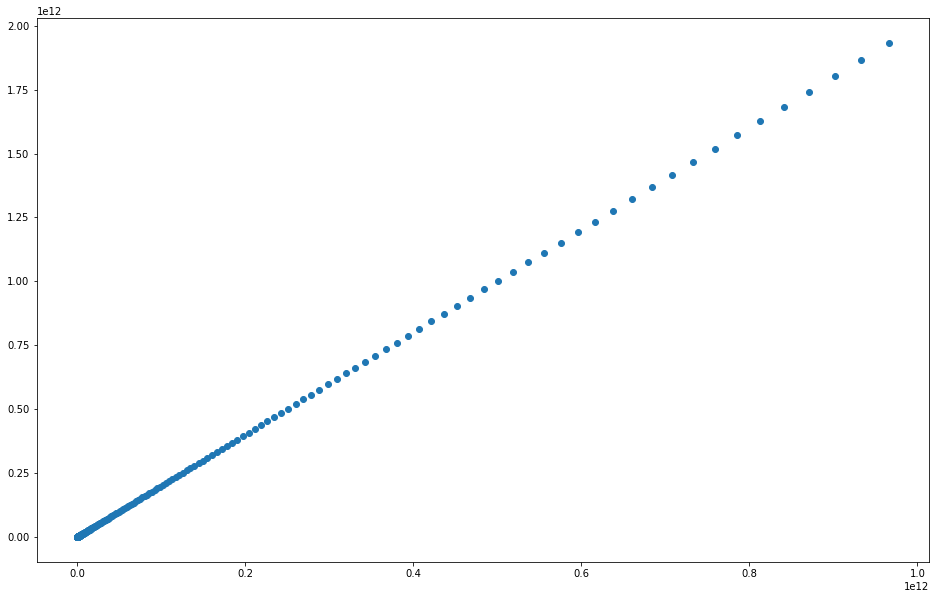

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.scatter(x**3, y)

We see that relationship is strictly linear 

Let's check branch_n_bound vs our algorithm on random samples of teams in order to compare results (and be sure that our smart matching works fine)

In [13]:
import tqdm

def check_smart_algorithm(times, data_size):
    for i in tqdm.tqdm(range(times)):
        ratings = np.random.choice(teams_ratings, (data_size))
        # sort pairs in result to get the same order as in branch_n_bound
        sm = sorted(
            list(map(
                lambda args: (min(args), max(args)),
                matching(ratings)
            )),
            key=lambda x: x[0]
        )
        bf = branch_n_bound(ratings)
        if sm != bf:
            print("failed, bf:", bf, " sm:", sm)
            
check_smart_algorithm(500, 6)
check_smart_algorithm(500, 7)

100%|██████████| 500/500 [00:11<00:00, 43.55it/s]


We see that two algorithms give the same results on small random datasets  